In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except json.JSONDecodeError:
        print("Metrics JSON at %s is not well-formed" % path)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func, max_epoch=None):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better. If `max_epoch` is provided, will
    only report everything up to this epoch (1-indexed).
    Returns the number of the run, the (one-indexed) number of the epoch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                if i == max_epoch:
                    break
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [5]:
def print_profile_losses(condition, max_epoch=None):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_batch_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [6]:
noprior_vals = print_profile_losses("BPNet")

Best profile loss overall:
Metrics JSON at /users/amtseng/att_priors/models/trained_models/profile/BPNet/3/metrics.json is not well-formed
	Best run: 2
	Best epoch in run: 18
	Associated value: 143.75121804942256
Best epoch in each run:
	Run 1, epoch 16: 143.78
	Run 2, epoch 18: 143.75
All validation profile and prior losses:
1
	165.28 160.38 158.04 154.88 154.76 153.43 152.73 152.30 151.98 152.09 151.79 153.06 152.37 151.59 151.60 151.46 153.55 151.48 152.65 151.70
	150.14 147.67 146.36 145.37 145.03 144.62 144.45 144.22 144.07 144.04 144.06 144.15 143.96 143.83 143.91 143.78 143.87 143.86 143.87 143.83
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	167.89 161.89 158.16 155.06 154.04 154.18 152.73 151.84 151.91 151.24 151.88 151.08 151.03 150.90 150.70 150.68 151.29 151.76 151.28 151.19
	152.20 147.85 146.59 145.98 145.24 144.85 144.97 144.30 144.14 144.03 144.01 143.99 143.85 143.97 143.7

In [7]:
prior_vals = print_profile_losses("BPNet_prior")

Best profile loss overall:
	Best run: 2
	Best epoch in run: 16
	Associated value: 145.2516603432154
Best epoch in each run:
	Run 1, epoch 7: 153.37
	Run 2, epoch 16: 145.25
	Run 3, epoch 2: 154.42
All validation profile and prior losses:
1
	179.21 172.13 169.91 169.58 170.29 171.39 171.51
	154.52 154.58 154.42 154.20 153.97 153.71 153.37
	0.0730 0.0513 0.0345 0.0433 0.0572 0.0774 0.0919
2
	173.80 169.33 173.29 167.93 163.15 161.01 161.30 159.33 160.01 163.36 160.15 160.53 159.00 158.43 158.52 160.79 160.82
	155.17 155.10 153.42 149.85 147.48 146.54 146.71 146.47 146.19 146.29 146.10 146.78 145.89 145.52 145.36 145.25 146.13
	0.0363 0.0288 0.1057 0.0899 0.0631 0.0581 0.0575 0.0555 0.0609 0.1094 0.0746 0.0702 0.0648 0.0626 0.0642 0.0661 0.0826
3
	176.11 171.53
	154.51 154.42
	0.0462 0.0549


Mean without priors: 143.766453
Mean with priors: 151.013279
-1.9377310623017954
0.07402015371238477


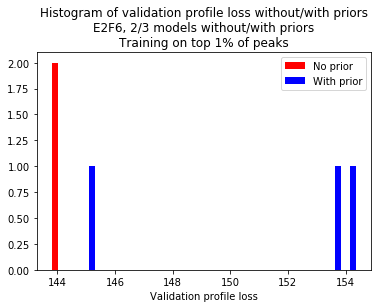

In [9]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss without/with priors"
title += "\nE2F6, %d/%d models without/with priors" % (len(noprior_vals), len(prior_vals))
title += "\nTraining on top 1% of peaks"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print("Mean without priors: %f" % np.mean(np_vals))
print("Mean with priors: %f" % np.mean(p_vals))
print(t)
print(p / 2)

In [11]:
def print_binary_losses(condition, max_epoch=None):
    models_path = "/users/amtseng/att_priors/models/trained_models/binary/%s/" % condition
    
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_batch_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [12]:
noprior_vals = print_binary_losses("BPNet")

Best validation loss overall:
	Best run: 17
	Best epoch in run: 1
	Associated value: 0.3528940501443127
Best epoch in each run:
	Run 1, epoch 1:  0.357
	Run 2, epoch 1:  0.361
	Run 3, epoch 1:  0.364
	Run 4, epoch 1:  0.365
	Run 5, epoch 1:  0.360
	Run 6, epoch 1:  0.353
	Run 7, epoch 1:  0.356
	Run 8, epoch 1:  0.354
	Run 9, epoch 1:  0.355
	Run 10, epoch 1:  0.353
	Run 11, epoch 1:  0.365
	Run 12, epoch 1:  0.358
	Run 13, epoch 1:  0.355
	Run 14, epoch 1:  0.365
	Run 15, epoch 1:  0.355
	Run 16, epoch 2:  0.364
	Run 17, epoch 1:  0.353
	Run 18, epoch 1:  0.354
	Run 19, epoch 1:  0.355
	Run 20, epoch 1:  0.363
All validation profile and prior losses:
1
	 0.357  0.365  0.389  0.425  0.464
	 0.357  0.365  0.389  0.425  0.464
	 0.000  0.000  0.000  0.000  0.000
2
	 0.361  0.363  0.403  0.441  0.477
	 0.361  0.363  0.403  0.441  0.477
	 0.000  0.000  0.000  0.000  0.000
3
	 0.364  0.368  0.393  0.420  0.464
	 0.364  0.368  0.393  0.420  0.464
	 0.000  0.000  0.000  0.000  0.000
4
	 0.365 

In [13]:
prior_vals = print_binary_losses("BPNet_prior")

Best validation loss overall:
	Best run: 2
	Best epoch in run: 10
	Associated value: 0.34942482992222434
Best epoch in each run:
	Run 1, epoch 20:  0.355
	Run 2, epoch 10:  0.349
	Run 3, epoch 1:  0.400
All validation profile and prior losses:
1
	 0.606  0.462  0.571  0.469  0.432  0.423  0.423  0.463  0.446  0.427  0.424  0.476  0.428  0.419  0.434  0.416  0.414  0.437  0.427  0.396
	 0.526  0.409  0.493  0.413  0.386  0.373  0.370  0.389  0.382  0.369  0.368  0.394  0.372  0.364  0.369  0.363  0.359  0.370  0.373  0.355
	 0.080  0.053  0.079  0.057  0.046  0.050  0.053  0.074  0.064  0.058  0.056  0.083  0.056  0.056  0.065  0.053  0.054  0.067  0.055  0.040
2
	 0.511  0.468  0.489  0.540  0.472  0.420  0.435  0.405  0.399  0.393  0.388  0.411  0.386  0.393  0.396  0.404
	 0.430  0.404  0.428  0.445  0.406  0.375  0.378  0.362  0.352  0.349  0.350  0.368  0.351  0.359  0.363  0.362
	 0.081  0.064  0.061  0.095  0.066  0.045  0.056  0.043  0.047  0.044  0.038  0.043  0.035  0.034  0.0

-1.6554346899670815
0.056352635574368405


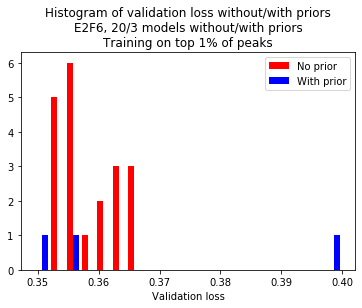

In [14]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation loss without/with priors"
title += "\nE2F6, %d/%d models without/with priors" % (len(noprior_vals), len(prior_vals))
title += "\nTraining on top 1% of peaks"
plt.title(title)
plt.xlabel("Validation loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)